In [13]:
import cv2
import keras
from keras.applications.imagenet_utils import preprocess_input
from keras.backend.tensorflow_backend import set_session
from keras.models import Model
from keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
import pickle
from random import shuffle
from scipy.misc import imread
from scipy.misc import imresize
import tensorflow as tf

from model.ssd512VGG16 import SSD
from ssd_training import MultiboxLoss
from ssd_utils import BBoxUtility

%matplotlib inline
plt.rcParams['figure.figsize'] = (8, 8)
plt.rcParams['image.interpolation'] = 'nearest'

np.set_printoptions(suppress=True)

# config = tf.ConfigProto()
# config.gpu_options.per_process_gpu_memory_fraction = 0.4
# set_session(tf.Session(config=config))

In [14]:
priors = pickle.load(open('priorFiles/prior_boxes_ssd512VGG16.pkl', 'rb'))
# print(priors[0])
# print(priors[1])
# print(priors[2])
# print(priors[50])
# print(priors[500])
# print(priors[1000])
# print(priors[7000])
# print(len(priors))
# print(priors.shape)
# test = pickle.load(open('original_.pkl', 'rb'))

In [15]:
# some constants
# NUM_CLASSES = 21
# input_shape = (2048, 1536, 3)
NUM_CLASSES = 6
input_shape = (512, 512, 3)

In [16]:
# priors = pickle.load(open('test_2.pkl', 'rb'))
# a = []
# # print(priors["1_100_1.jpg"])
# for name in priors.keys():
#     print(priors[name])
#     print("\n")
#     a.append(priors[name])
bbox_util = BBoxUtility(NUM_CLASSES,priors)

In [17]:
gt = pickle.load(open('original_512_5.pkl', 'rb'))
keys = sorted(gt.keys())
num_train = len(keys)
# num_train = int(round(0.8 * len(keys)))
train_keys = keys
# val_keys = keys[num_train:]
# num_val = len(val_keys)

In [18]:
class Generator(object):
    def __init__(self, gt, bbox_util,
                 batch_size, path_prefix,
                 train_keys, val_keys, image_size,
                 saturation_var=0.5,
                 brightness_var=0.5,
                 contrast_var=0.5,
                 lighting_std=0.5,
                 hflip_prob=0.5,
                 vflip_prob=0.5,
                 do_crop=True,
                 crop_area_range=[0.75, 1.0],
                 aspect_ratio_range=[3./4., 4./3.]):
        self.gt = gt
        self.bbox_util = bbox_util
        self.batch_size = batch_size
        self.path_prefix = path_prefix
        self.train_keys = train_keys
        self.val_keys = val_keys
        self.train_batches = len(train_keys)
        self.val_batches = len(val_keys)
        self.image_size = image_size
        self.color_jitter = []
        if saturation_var:
            self.saturation_var = saturation_var
            self.color_jitter.append(self.saturation)
        if brightness_var:
            self.brightness_var = brightness_var
            self.color_jitter.append(self.brightness)
        if contrast_var:
            self.contrast_var = contrast_var
            self.color_jitter.append(self.contrast)
        self.lighting_std = lighting_std
        self.hflip_prob = hflip_prob
        self.vflip_prob = vflip_prob
        self.do_crop = do_crop
        self.crop_area_range = crop_area_range
        self.aspect_ratio_range = aspect_ratio_range
        
    def grayscale(self, rgb):
        return rgb.dot([0.299, 0.587, 0.114])

    def saturation(self, rgb):
        gs = self.grayscale(rgb)
        alpha = 2 * np.random.random() * self.saturation_var 
        alpha += 1 - self.saturation_var
        rgb = rgb * alpha + (1 - alpha) * gs[:, :, None]
        return np.clip(rgb, 0, 255)

    def brightness(self, rgb):
        alpha = 2 * np.random.random() * self.brightness_var 
        alpha += 1 - self.saturation_var
        rgb = rgb * alpha
        return np.clip(rgb, 0, 255)

    def contrast(self, rgb):
        gs = self.grayscale(rgb).mean() * np.ones_like(rgb)
        alpha = 2 * np.random.random() * self.contrast_var 
        alpha += 1 - self.contrast_var
        rgb = rgb * alpha + (1 - alpha) * gs
        return np.clip(rgb, 0, 255)

    def lighting(self, img):
        cov = np.cov(img.reshape(-1, 3) / 255.0, rowvar=False)
        eigval, eigvec = np.linalg.eigh(cov)
        noise = np.random.randn(3) * self.lighting_std
        noise = eigvec.dot(eigval * noise) * 255
        img += noise
        return np.clip(img, 0, 255)
    
    def horizontal_flip(self, img, y):
        if np.random.random() < self.hflip_prob:
            img = img[:, ::-1]
            y[:, [0, 2]] = 1 - y[:, [2, 0]]
        return img, y
    
    def vertical_flip(self, img, y):
        if np.random.random() < self.vflip_prob:
            img = img[::-1]
            y[:, [1, 3]] = 1 - y[:, [3, 1]]
        return img, y
    
    def random_sized_crop(self, img, targets):
        img_w = img.shape[1]
        img_h = img.shape[0]
        img_area = img_w * img_h
        random_scale = np.random.random()
        random_scale *= (self.crop_area_range[1] -
                         self.crop_area_range[0])
        random_scale += self.crop_area_range[0]
        target_area = random_scale * img_area
        random_ratio = np.random.random()
        random_ratio *= (self.aspect_ratio_range[1] -
                         self.aspect_ratio_range[0])
        random_ratio += self.aspect_ratio_range[0]
        w = np.round(np.sqrt(target_area * random_ratio))     
        h = np.round(np.sqrt(target_area / random_ratio))
        if np.random.random() < 0.5:
            w, h = h, w
        w = min(w, img_w)
        w_rel = w / img_w
        w = int(w)
        h = min(h, img_h)
        h_rel = h / img_h
        h = int(h)
        x = np.random.random() * (img_w - w)
        x_rel = x / img_w
        x = int(x)
        y = np.random.random() * (img_h - h)
        y_rel = y / img_h
        y = int(y)
        img = img[y:y+h, x:x+w]
        new_targets = []
        for box in targets:
            cx = 0.5 * (box[0] + box[2])
            cy = 0.5 * (box[1] + box[3])
            if (x_rel < cx < x_rel + w_rel and
                y_rel < cy < y_rel + h_rel):
                xmin = (box[0] - x_rel) / w_rel
                ymin = (box[1] - y_rel) / h_rel
                xmax = (box[2] - x_rel) / w_rel
                ymax = (box[3] - y_rel) / h_rel
                xmin = max(0, xmin)
                ymin = max(0, ymin)
                xmax = min(1, xmax)
                ymax = min(1, ymax)
                box[:4] = [xmin, ymin, xmax, ymax]
                new_targets.append(box)
        new_targets = np.asarray(new_targets).reshape(-1, targets.shape[1])
        return img, new_targets
    
    def generate(self, train=True):
        while True:
            if train:
                shuffle(self.train_keys)
                keys = self.train_keys
            else:
                shuffle(self.val_keys)
                keys = self.val_keys
            inputs = []
            targets = []
            for key in keys:            
                img_path = self.path_prefix + key
                img = imread(img_path).astype('float32')
                y = self.gt[key].copy()
                if train and self.do_crop:
                    img, y = self.random_sized_crop(img, y)
                img = imresize(img, self.image_size).astype('float32')
                if train:
                    shuffle(self.color_jitter)
                    for jitter in self.color_jitter:
                        img = jitter(img)
                    if self.lighting_std:
                        img = self.lighting(img)
                    if self.hflip_prob > 0:
                        img, y = self.horizontal_flip(img, y)
                    if self.vflip_prob > 0:
                        img, y = self.vertical_flip(img, y)
                y = self.bbox_util.assign_boxes(y)
                inputs.append(img)                
                targets.append(y)
                if len(targets) == self.batch_size:
                    tmp_inp = np.array(inputs)
                    tmp_targets = np.array(targets)
                    inputs = []
                    targets = []
                    yield preprocess_input(tmp_inp), tmp_targets

In [20]:
path_prefix = 'csp_dataset_class_5/train/'
gen = Generator(gt, bbox_util, 1,path_prefix,
                train_keys, ["0"],
                (input_shape[0], input_shape[1]), do_crop=False)

In [21]:
model = SSD(input_shape, num_classes=NUM_CLASSES)
# model.load_weights('VGG16SSD300_weights_voc_2007.hdf5', by_name=True)
#model.load_weights('VGG16SSD300weights_loss0.1_acc_0.4_mAp72__.hdf5', by_name=True)

In [22]:
freeze = ['input_1', 'conv1_1', 'conv1_2', 'pool1',
          'conv2_1', 'conv2_2', 'pool2',
          'conv3_1', 'conv3_2', 'conv3_3', 'pool3']#,
#           'conv4_1', 'conv4_2', 'conv4_3', 'pool4']

for L in model.layers:
    if L.name in freeze:
        L.trainable = False

In [23]:
def schedule(epoch, decay=0.9):
    return base_lr * decay**(epoch)

callbacks = [keras.callbacks.ModelCheckpoint('./checkpoints/weights.{epoch:02d}-{val_loss:.2f}.hdf5',
                                             verbose=1,
                                             save_weights_only=True),
             keras.callbacks.LearningRateScheduler(schedule)]

In [24]:
base_lr = 3e-4
optim = keras.optimizers.Adam(lr=base_lr)
# optim = keras.optimizers.RMSprop(lr=base_lr)
# optim = keras.optimizers.SGD(lr=base_lr, momentum=0.9, decay=decay, nesterov=True)
model.compile(optimizer=optim,
              loss=MultiboxLoss(NUM_CLASSES, neg_pos_ratio=2.0).compute_loss,metrics=['acc'])

In [25]:
nb_epoch = 1
history = model.fit_generator(gen.generate(True), gen.train_batches,
                              nb_epoch, verbose=1,
                              callbacks=callbacks,
                              validation_data=gen.generate(False),
                              nb_val_samples=gen.val_batches,
                              nb_worker=1)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  import sys
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., 21600, 1, validation_steps=1, validation_data=<generator..., workers=1, verbose=1, callbacks=[<keras.ca...)`
  import sys


Epoch 1/1
boxes [[0.25       0.2421875  0.27148438 0.31054688 0.         1.
  0.         0.         0.        ]
 [0.25       0.125      0.3828125  0.50390625 1.         0.
  0.         0.         0.        ]]
self.num_priors: 24564
self.num_classes: 6
assignment: [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
assignment.shape: (24564, 18)
box [0.25       0.2421875  0.27148438 0.31054688]
box [0.25       0.125      0.3828125  0.50390625]
encoded_boxes: [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
best_iou_idx: [0 1 1 1 1 1 1 1]
assign_num 8
best_iou_mask: [False False False ... False False False]
best_iou_idx [0 1 1 1 1 1 1 1]
boxes [[0.69140625 0.63476562 0.70507812 0.67578125 0.         1.
  0.         0.         0.        ]
 [0.68945312 0.52539062 0.76953125 0.73828125 1.         0.
  0.         0.         0.        ]]
self.num_priors: 24564
self.num_classes: 6
assignmen

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:144: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:148: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.


box [0.68945312 0.52539062 0.76953125 0.73828125]
encoded_boxes: [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
best_iou_idx: [0 1 1 1 1 1 1 1 1]
assign_num 9
best_iou_mask: [False False False ... False False False]
best_iou_idx [0 1 1 1 1 1 1 1 1]
boxes [[0.37695312 0.796875   0.40234375 0.859375   0.         1.
  0.         0.         0.        ]
 [0.28125    0.61132812 0.3984375  0.98046875 1.         0.
  0.         0.         0.        ]]
self.num_priors: 24564
self.num_classes: 6
assignment: [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
assignment.shape: (24564, 18)
box [0.37695312 0.796875   0.40234375 0.859375  ]
box [0.28125    0.61132812 0.3984375  0.98046875]
encoded_boxes: [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
best_iou_idx: [0 1 1 1 1 1 1 1 1]
assign_num 9
best_iou_mask: [False False False ... False False False]
best_iou_idx [0 1 1 1 1 1 1 1 1]
boxe

    2/21600 [..............................] - ETA: 11:06:31 - loss: 285.8540 - acc: 0.0050boxes [[0.7265625  0.18945312 0.93359375 0.50976562 0.         0.
  1.         0.         0.        ]
 [0.84960938 0.21679688 0.9609375  0.69921875 1.         0.
  0.         0.         0.        ]]
self.num_priors: 24564
self.num_classes: 6
assignment: [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
assignment.shape: (24564, 18)
box [0.7265625  0.18945312 0.93359375 0.50976562]
box [0.84960938 0.21679688 0.9609375  0.69921875]
encoded_boxes: [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
best_iou_idx: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 0]
assign_num 37
best_iou_mask: [False False False ... False False False]
best_iou_idx [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 0]
    3/21600 [..............................] - ETA: 7

   12/21600 [..............................] - ETA: 2:44:26 - loss: 97.5327 - acc: 0.0167 boxes [[0.42382812 0.4375     0.44140625 0.47460938 0.         1.
  0.         0.         0.        ]
 [0.41992188 0.36328125 0.47265625 0.58203125 1.         0.
  0.         0.         0.        ]]
self.num_priors: 24564
self.num_classes: 6
assignment: [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
assignment.shape: (24564, 18)
box [0.42382812 0.4375     0.44140625 0.47460938]
box [0.41992188 0.36328125 0.47265625 0.58203125]
encoded_boxes: [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
best_iou_idx: [0 1 1]
assign_num 3
best_iou_mask: [False False False ... False False False]
best_iou_idx [0 1 1]
   13/21600 [..............................] - ETA: 2:36:59 - loss: 90.4635 - acc: 0.0206boxes [[0.26171875 0.59375    0.3046875  0.6171875  0.         1.
  0.         0.         0.        ]


   21/21600 [..............................] - ETA: 2:01:49 - loss: 57.7367 - acc: 0.0900boxes [[0.609375   0.26953125 0.6484375  0.30273438 0.         0.
  0.         0.         1.        ]
 [0.609375   0.00390625 0.78710938 0.39648438 1.         0.
  0.         0.         0.        ]]
self.num_priors: 24564
self.num_classes: 6
assignment: [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
assignment.shape: (24564, 18)
box [0.609375   0.26953125 0.6484375  0.30273438]
box [0.609375   0.00390625 0.78710938 0.39648438]
encoded_boxes: [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
best_iou_idx: [0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
assign_num 23
best_iou_mask: [False False False ... False False False]
best_iou_idx [0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
   22/21600 [..............................] - ETA: 1:59:15 - loss: 55.3217 - acc: 0.0940boxes [[0.6328125  0.6

   31/21600 [..............................] - ETA: 1:43:07 - loss: 40.6219 - acc: 0.1257boxes [[0.37890625 0.578125   0.41601562 0.60742188 0.         1.
  0.         0.         0.        ]
 [0.29296875 0.41015625 0.43359375 0.74804688 1.         0.
  0.         0.         0.        ]]
self.num_priors: 24564
self.num_classes: 6
assignment: [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
assignment.shape: (24564, 18)
box [0.37890625 0.578125   0.41601562 0.60742188]
box [0.29296875 0.41015625 0.43359375 0.74804688]
encoded_boxes: [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
best_iou_idx: [0 1 1 1 1 1]
assign_num 6
best_iou_mask: [False False False ... False False False]
best_iou_idx [0 1 1 1 1 1]
   32/21600 [..............................] - ETA: 1:42:01 - loss: 39.5301 - acc: 0.1282boxes [[0.51953125 0.41601562 0.66210938 0.63085938 0.         0.
  1.         0.         0

   41/21600 [..............................] - ETA: 1:33:49 - loss: 31.7496 - acc: 0.1399boxes [[0.85546875 0.47460938 0.88476562 0.625      0.         0.
  0.         1.         0.        ]
 [0.77539062 0.36132812 0.87304688 0.66601562 1.         0.
  0.         0.         0.        ]]
self.num_priors: 24564
self.num_classes: 6
assignment: [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
assignment.shape: (24564, 18)
box [0.85546875 0.47460938 0.88476562 0.625     ]
box [0.77539062 0.36132812 0.87304688 0.66601562]
encoded_boxes: [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
best_iou_idx: [0 1 1 1 1 1 1 1 1 1 1]
assign_num 11
best_iou_mask: [False False False ... False False False]
best_iou_idx [0 1 1 1 1 1 1 1 1 1 1]
   42/21600 [..............................] - ETA: 1:33:11 - loss: 31.0858 - acc: 0.1402boxes [[0.69726562 0.56054688 0.71289062 0.69335938 0.         0.
  0.

   51/21600 [..............................] - ETA: 1:28:15 - loss: 26.2846 - acc: 0.1358boxes [[0.75976562 0.27539062 0.78125    0.32421875 0.         1.
  0.         0.         0.        ]
 [0.70898438 0.20117188 0.78710938 0.45507812 1.         0.
  0.         0.         0.        ]]
self.num_priors: 24564
self.num_classes: 6
assignment: [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
assignment.shape: (24564, 18)
box [0.75976562 0.27539062 0.78125    0.32421875]
box [0.70898438 0.20117188 0.78710938 0.45507812]
encoded_boxes: [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
best_iou_idx: [0 1 1 1 1 1 1 1 1 1 1 1 1]
assign_num 13
best_iou_mask: [False False False ... False False False]
best_iou_idx [0 1 1 1 1 1 1 1 1 1 1 1 1]
   52/21600 [..............................] - ETA: 1:27:55 - loss: 25.8605 - acc: 0.1354boxes [[0.         0.4140625  0.1484375  0.88085938 0.        

   60/21600 [..............................] - ETA: 1:24:46 - loss: 22.9309 - acc: 0.1357boxes [[0.86914062 0.265625   0.95507812 0.38085938 0.         1.
  0.         0.         0.        ]]
self.num_priors: 24564
self.num_classes: 6
assignment: [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
assignment.shape: (24564, 18)
box [0.86914062 0.265625   0.95507812 0.38085938]
encoded_boxes: [[0. 0. 0. ... 0. 0. 0.]]
best_iou_idx: [0 0 0 0 0 0 0 0 0 0 0 0]
assign_num 12
best_iou_mask: [False False False ... False False False]
best_iou_idx [0 0 0 0 0 0 0 0 0 0 0 0]
   61/21600 [..............................] - ETA: 1:24:26 - loss: 22.6094 - acc: 0.1342boxes [[0.45703125 0.3984375  0.609375   0.75390625 0.         0.
  1.         0.         0.        ]
 [0.58007812 0.44335938 0.72265625 0.94335938 1.         0.
  0.         0.         0.        ]]
self.num_priors: 24564
self.num_classe

   70/21600 [..............................] - ETA: 1:21:54 - loss: 20.2035 - acc: 0.1265boxes [[0.03320312 0.7890625  0.16601562 0.88085938 0.         1.
  0.         0.         0.        ]
 [0.00195312 0.30859375 0.35742188 1.         1.         0.
  0.         0.         0.        ]]
self.num_priors: 24564
self.num_classes: 6
assignment: [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
assignment.shape: (24564, 18)
box [0.03320312 0.7890625  0.16601562 0.88085938]
box [0.00195312 0.30859375 0.35742188 1.        ]
encoded_boxes: [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
best_iou_idx: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
assign_num 56
best_iou_mask: [False False False ... False False False]
best_iou_idx [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 

KeyboardInterrupt: 

In [31]:
inputs = []
images = []
img_path = path_prefix + sorted(val_keys)[300]
img = image.load_img(img_path, target_size=(512, 512))
img = image.img_to_array(img)
images.append(imread(img_path))
inputs.append(img.copy())
inputs = preprocess_input(np.array(inputs))

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  


In [32]:
preds = model.predict(inputs, batch_size=1, verbose=1)
results = bbox_util.detection_out(preds)

1/1 [==============================] - 0s 67ms/step
mbox_priorbox [[0.         0.         0.0428125  0.0428125 ]
 [0.         0.         0.05904726 0.05904726]
 [0.         0.         0.05730997 0.03256124]
 ...
 [0.01394445 0.01394445 0.98605555 0.98605555]
 [0.         0.18180194 1.         0.818198  ]
 [0.18180194 0.         0.818198   1.        ]]


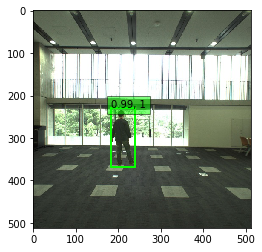

In [33]:
for i, img in enumerate(images):
    # Parse the outputs.
    det_label = results[i][:, 0]
    det_conf = results[i][:, 1]
    det_xmin = results[i][:, 2]
    det_ymin = results[i][:, 3]
    det_xmax = results[i][:, 4]
    det_ymax = results[i][:, 5]

    # Get detections with confidence higher than 0.6.
    top_indices = [i for i, conf in enumerate(det_conf) if conf >= 0.6]

    top_conf = det_conf[top_indices]
    top_label_indices = det_label[top_indices].tolist()
    top_xmin = det_xmin[top_indices]
    top_ymin = det_ymin[top_indices]
    top_xmax = det_xmax[top_indices]
    top_ymax = det_ymax[top_indices]

    colors = plt.cm.hsv(np.linspace(0, 1, 4)).tolist()

    plt.imshow(img / 255.)
    currentAxis = plt.gca()

    for i in range(top_conf.shape[0]):
        xmin = int(round(top_xmin[i] * img.shape[1]))
        ymin = int(round(top_ymin[i] * img.shape[0]))
        xmax = int(round(top_xmax[i] * img.shape[1]))
        ymax = int(round(top_ymax[i] * img.shape[0]))
        score = top_conf[i]
        label = int(top_label_indices[i])
#         label_name = voc_classes[label - 1]
        display_txt = '{:0.2f}, {}'.format(score, label)
        coords = (xmin, ymin), xmax-xmin+1, ymax-ymin+1
        color = colors[label]
        currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
        currentAxis.text(xmin, ymin, display_txt, bbox={'facecolor':color, 'alpha':0.5})
    
    plt.show()